In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
#if the GPU is available use it for the computation otherwise use the CPU.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#There are 2 ways to load the Fashion MNIST dataset.

#There are 2 ways to load the Fashion MNIST dataset.

#1.   Load csv and then inherite Pytorch Dataset class .
#2.   Use Pytorch module torchvision.datasets. It has many popular datasets like MNIST, FashionMNIST, CIFAR10 e.t.c

#Note: We use DataLoader class from torch.utils.data to load data in batches in both method.

In [2]:
#Using FashionMNIST class from torchvision module.
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [01:17<00:00, 339580.51it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 145964.74it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:06<00:00, 690124.20it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 2885510.76it/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [3]:
len(train_set)

60000

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

In [5]:
len(train_loader)

600

In [6]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

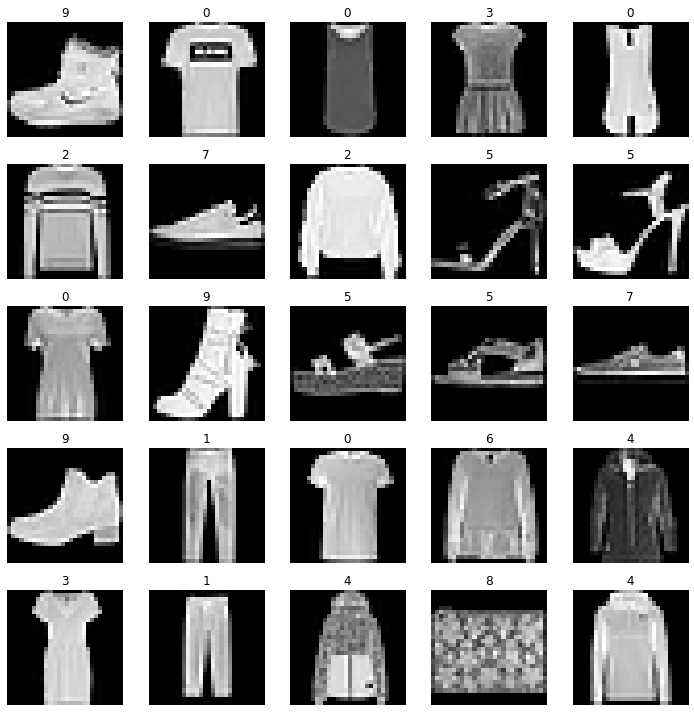

In [7]:
#displaying some datapoints
images, labels = next(iter(train_loader))

# Visualize the images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(str(labels[i].item()))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
#Building a CNN
"""
Make a model class (FashionCNN in our case)
It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
Our Neural Net has following layers:

Two Sequential layers each consists of following layers-

Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
Batch Normalization layer.
Acitvation function: ReLU.
Max Pooling layer with kernel size of 2 * 2 and stride 2.
Flatten out the output for dense layer(a.k.a. fully connected layer).
3 Fully connected layer with different in/out features.
1 Dropout layer that has class probability p = 0.25.
All the functionaltiy is given in forward method that defines the forward pass of CNN.
Our input image is changing in a following way:
First Convulation layer : input: 28 * 28 * 3, output: 28 * 28 * 32
First Max Pooling layer : input: 28 * 28 * 32, output: 14 * 14 * 32
Second Conv layer : input : 14 * 14 * 32, output: 12 * 12 * 64
Second Max Pooling layer : 12 * 12 * 64, output: 6 * 6 * 64
Final fully connected layer has 10 output features for 10 types of clothes.
Lets implementing the network...

"""

'\nMake a model class (FashionCNN in our case)\nIt inherit nn.Module class that is a super class for all the neural networks in Pytorch.\nOur Neural Net has following layers:\n\nTwo Sequential layers each consists of following layers-\n\nConvolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.\nBatch Normalization layer.\nAcitvation function: ReLU.\nMax Pooling layer with kernel size of 2 * 2 and stride 2.\nFlatten out the output for dense layer(a.k.a. fully connected layer).\n3 Fully connected layer with different in/out features.\n1 Dropout layer that has class probability p = 0.25.\nAll the functionaltiy is given in forward method that defines the forward pass of CNN.\nOur input image is changing in a following way:\nFirst Convulation layer : input: 28 * 28 * 3, output: 28 * 28 * 32\nFirst Max Pooling layer : input: 28 * 28 * 32, output: 14 * 14 * 32\nSecond Conv layer : input : 14 * 14 * 32, o

In [9]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
#Making a model of our CNN class
"""
Creating a object(model in the code)
Transfering it into GPU if available.
Defining a Loss function. we're using CrossEntropyLoss() here.
Using Adam algorithm for optimization purpose.
"""

In [11]:
model = FashionCNN()
# model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        # images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                # images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1]
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

NameError: name 'device' is not defined

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
#Looking the Accuracy in each class of FashionMNIST dataset

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))